In [176]:
#General imports

In [177]:
import os
import joblib

In [178]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
from plotly.offline import init_notebook_mode

In [179]:
import warnings
warnings.filterwarnings('ignore')

In [180]:
#Machine Learning imports

In [181]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [182]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict

In [183]:
from sklearn.linear_model import SGDRegressor, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import ExtraTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, BaggingRegressor, StackingRegressor

In [184]:
from sklearn.metrics import mean_squared_error, r2_score

# 1. Data Import & Aggregation

In [185]:
DATA_PATH = 'C:\\My Work\\Projects\\Machine Learning\\Walmart Sales Forecasting\\datasets\\'#local folder

In [186]:
print('Loading data...')
print(os.listdir(DATA_PATH))

Loading data...
['features.csv', 'stores.csv', 'test.csv', 'train.csv']


In [187]:
FEATURE_PATH = DATA_PATH + 'features.csv'
STORES_PATH = DATA_PATH + 'stores.csv'
TRAIN_PATH = DATA_PATH + 'train.csv'
TEST_PATH = DATA_PATH + 'test.csv'

In [188]:
#Created variables for each dataset path is to make this portion less dependent.
#Even if I need to change or move the data to somewhere else, the effort will be minimal
#A better option would have been to create a config file for the same.

In [189]:
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
features = pd.read_csv(FEATURE_PATH)
stores = pd.read_csv(STORES_PATH)

In [190]:
train.head(20)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [191]:
test.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


In [192]:
features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [193]:
stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [194]:
#merging the data

class DataMerger(BaseEstimator, TransformerMixin):
    def __init__(self,fpath = FEATURE_PATH, spath = STORES_PATH):
        self.fpath = fpath
        self.spath = spath
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        feature = pd.read_csv(self.fpath)
        store = pd.read_csv(self.spath)
        df = X.merge(feature, how = 'inner', on =['Store', 'Date', 'IsHoliday'])
        df = df.merge(store, how = 'inner', on =['Store'])
        return df

In [195]:
dm = DataMerger(FEATURE_PATH, STORES_PATH)
trainSales = dm.transform(train)
trainSales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315


# 2. Data Analysis

In [196]:
trainSales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
 5   Temperature   421570 non-null  float64
 6   Fuel_Price    421570 non-null  float64
 7   MarkDown1     150681 non-null  float64
 8   MarkDown2     111248 non-null  float64
 9   MarkDown3     137091 non-null  float64
 10  MarkDown4     134967 non-null  float64
 11  MarkDown5     151432 non-null  float64
 12  CPI           421570 non-null  float64
 13  Unemployment  421570 non-null  float64
 14  Type          421570 non-null  object 
 15  Size          421570 non-null  int64  
dtypes: bool(1), float64(10), int64(3), object(2)
memory usage: 51.9+ MB


In [197]:
target = ['Weekly_Sales']
markDown = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
numCols = ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Size']
otherCols = []

for col in trainSales.columns:
    if (col not in numCols) and (col not in target) and (col not in markDown):
        otherCols.append(col)
        
otherCols

['Store', 'Dept', 'Date', 'IsHoliday', 'Type']

***Check IsHoliday***

In [198]:
trainSales['IsHoliday'].value_counts()

False    391909
True      29661
Name: IsHoliday, dtype: int64

In [199]:
#Create a new column with values 1 & 0 for True & False respectively

# ohe = OneHotEncoder(drop='first', dtype='int')
# holidayDummies = ohe.fit_transform(trainSales[['IsHoliday']]).toarray()
# trainSales['HolidayFlag'] = holidayDummies
# holidaySales = trainSales.drop(columns = ['IsHoliday'], axis=1)
# holidaySales.head()

In [200]:
trainSales['HolidayFlag'] = trainSales['IsHoliday'].apply(lambda x : 0 if x == False else 1)
holidaySales = trainSales.drop(columns = ['IsHoliday'], axis=1)
holidaySales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,HolidayFlag
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,A,151315,0


***Check Type***

In [201]:
holidaySales['Type'].value_counts()

A    215478
B    163495
C     42597
Name: Type, dtype: int64

In [202]:
#Create dummies using OneHotEncoding

ohe = OneHotEncoder(dtype='int')
typeDummies = ohe.fit_transform(holidaySales[['Type']]).toarray()
holidaySales[['type_A', 'type_B', 'type_C']] = typeDummies
typeSales = holidaySales.drop(['Type'], axis=1)
typeSales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,HolidayFlag,type_A,type_B,type_C
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,151315,0,1,0,0


***Check Date***

In [203]:
#Lets have seperate columns for month, year and week
#Can we also get the date whether it is weekend or not?

typeSales['Year'] = typeSales['Date'].astype('datetime64').dt.year
typeSales['Month'] = typeSales['Date'].astype('datetime64').dt.month
typeSales['WeekDay'] = typeSales['Date'].astype('datetime64').dt.weekday
typeSales['Week'] = typeSales['Date'].astype('datetime64').dt.isocalendar().week
typeSales.head()

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,...,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month,WeekDay,Week
0,1,1,2010-02-05,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,4,5
1,1,2,2010-02-05,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,4,5
2,1,3,2010-02-05,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,4,5
3,1,4,2010-02-05,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,4,5
4,1,5,2010-02-05,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,4,5


In [204]:
typeSales['Date']

0         2010-02-05
1         2010-02-05
2         2010-02-05
3         2010-02-05
4         2010-02-05
             ...    
421565    2012-10-26
421566    2012-10-26
421567    2012-10-26
421568    2012-10-26
421569    2012-10-26
Name: Date, Length: 421570, dtype: object

In [205]:
typeSales['Date'].unique()

array(['2010-02-05', '2010-02-12', '2010-02-19', '2010-02-26',
       '2010-03-05', '2010-03-12', '2010-03-19', '2010-03-26',
       '2010-04-02', '2010-04-09', '2010-04-16', '2010-04-23',
       '2010-04-30', '2010-05-07', '2010-05-14', '2010-05-21',
       '2010-05-28', '2010-06-04', '2010-06-11', '2010-06-18',
       '2010-06-25', '2010-07-02', '2010-07-09', '2010-07-16',
       '2010-07-23', '2010-07-30', '2010-08-06', '2010-08-13',
       '2010-08-20', '2010-08-27', '2010-09-03', '2010-09-10',
       '2010-09-17', '2010-09-24', '2010-10-01', '2010-10-08',
       '2010-10-15', '2010-10-22', '2010-10-29', '2010-11-05',
       '2010-11-12', '2010-11-19', '2010-11-26', '2010-12-03',
       '2010-12-10', '2010-12-17', '2010-12-24', '2010-12-31',
       '2011-01-07', '2011-01-14', '2011-01-21', '2011-01-28',
       '2011-02-04', '2011-02-11', '2011-02-18', '2011-02-25',
       '2011-03-04', '2011-03-11', '2011-03-18', '2011-03-25',
       '2011-04-01', '2011-04-08', '2011-04-15', '2011-

In [206]:
typeSales['WeekDay'].unique()

array([4], dtype=int64)

In [207]:
#Due to some reason it is being observed that sales information taken only on Friday 
#and not on other days regardless of the year

#If that is true then maybe we need to revisit our strategy on the date columns 

#We do not need any validation for weekend 'coz no date ins a weekend.

In [142]:
typeSales['Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [208]:
typeSales.shape

(421570, 22)

In [209]:
typeSales.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
Temperature          0
Fuel_Price           0
MarkDown1       270889
MarkDown2       310322
MarkDown3       284479
MarkDown4       286603
MarkDown5       270138
CPI                  0
Unemployment         0
Size                 0
HolidayFlag          0
type_A               0
type_B               0
type_C               0
Year                 0
Month                0
WeekDay              0
Week                 0
dtype: int64

In [210]:
#More than half of the rows are null.
#Since I do not have much information available about these columns, removing these.

sales = typeSales.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown4', 'MarkDown5'])
sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   Temperature   421570 non-null  float64
 5   Fuel_Price    421570 non-null  float64
 6   CPI           421570 non-null  float64
 7   Unemployment  421570 non-null  float64
 8   Size          421570 non-null  int64  
 9   HolidayFlag   421570 non-null  int64  
 10  type_A        421570 non-null  int32  
 11  type_B        421570 non-null  int32  
 12  type_C        421570 non-null  int32  
 13  Year          421570 non-null  int64  
 14  Month         421570 non-null  int64  
 15  WeekDay       421570 non-null  int64  
 16  Week          421570 non-null  UInt32 
dtypes: UInt32(1), float64(5), int32(3), int64(7), ob

In [175]:
sales.isnull().sum()

Store                0
Dept                 0
Date                 0
Weekly_Sales         0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
Size                 0
HolidayFlag          0
type_A               0
type_B               0
type_C               0
Year                 0
Month                0
WeekDay              0
Week                 0
IsWeekend            0
MarkDown        324514
dtype: int64

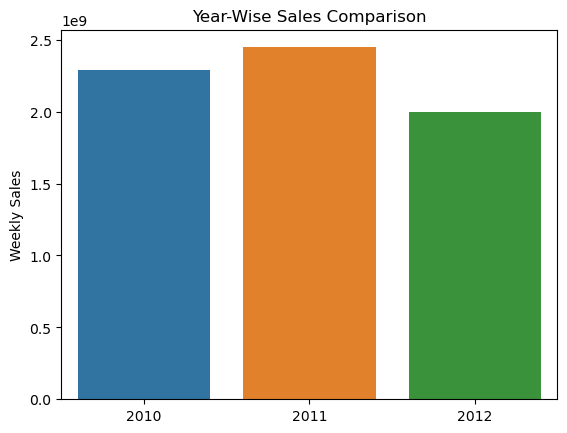

In [161]:
#Lets try to plot the sales per year


sns.barplot(x = years , y = list(total_sales.values()))
plt.title('Year-Wise Sales Comparison')
plt.ylabel('Weekly Sales')
plt.show()

<AxesSubplot:xlabel='Month', ylabel='Weekly_Sales'>

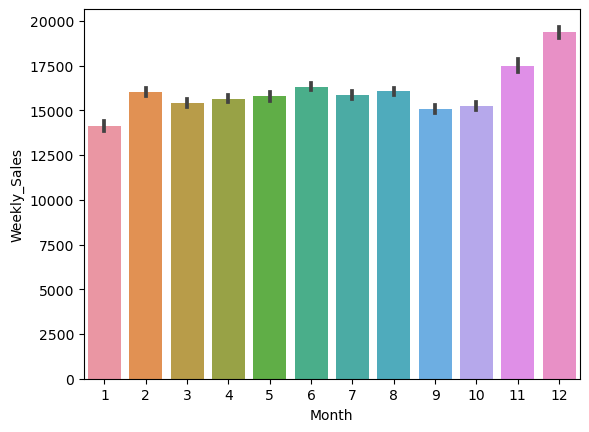

In [167]:
sns.barplot(x = 'Month', y = 'Weekly_Sales', data=typeSales)

In [118]:
#Assumption is that the week starts from Monday denoted as 0
#Meaning Saturday & Sunday is denoted by 5 & 6 repectively.

typeSales['IsWeekend'] = typeSales['WeekDay'].apply(lambda x : 1 if x in [5, 6] else 0)
dateSales = typeSales.drop(['Date', 'WeekDay'], axis=1)
dateSales.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month,Week,IsWeekend
0,1,1,24924.50,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,5,0
1,1,2,50605.27,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,5,0
2,1,3,13740.12,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,5,0
3,1,4,39954.04,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,5,0
4,1,5,32229.38,42.31,2.572,NaN,NaN,NaN,NaN,NaN,...,8.106,151315,0,1,0,0,2010,2,5,0


***Markdown Columns***

In [119]:
dateSales.loc[dateSales['MarkDown1'].isnull(), 'Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [120]:
dateSales.loc[dateSales['MarkDown2'].isnull(), 'Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [121]:
dateSales.loc[dateSales['MarkDown3'].isnull(), 'Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [122]:
dateSales.loc[dateSales['MarkDown4'].isnull(), 'Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [123]:
dateSales['Year'].unique()

array([2010, 2011, 2012], dtype=int64)

In [124]:
#Since MarkDown fields are based on stores, we can try getting the mean for each store and populate the nans

cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
stores = dateSales['Store'].unique()
markSales = dateSales.copy()
for store in stores:
    for col in cols:
        #ds[col].fillna(value=0)
        avg = markSales.loc[markSales['Store'] == store, col].mean()
        markSales.loc[markSales[col].isnull(), col] = round(avg, 4)
        
markSales.isnull().sum()

Store           0
Dept            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Size            0
HolidayFlag     0
type_A          0
type_B          0
type_C          0
Year            0
Month           0
Week            0
IsWeekend       0
dtype: int64

In [125]:
markSales.head()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,...,Unemployment,Size,HolidayFlag,type_A,type_B,type_C,Year,Month,Week,IsWeekend
0,1,1,24924.50,42.31,2.572,8086.7303,2967.1649,1245.4035,3755.2104,5027.7469,...,8.106,151315,0,1,0,0,2010,2,5,0
1,1,2,50605.27,42.31,2.572,8086.7303,2967.1649,1245.4035,3755.2104,5027.7469,...,8.106,151315,0,1,0,0,2010,2,5,0
2,1,3,13740.12,42.31,2.572,8086.7303,2967.1649,1245.4035,3755.2104,5027.7469,...,8.106,151315,0,1,0,0,2010,2,5,0
3,1,4,39954.04,42.31,2.572,8086.7303,2967.1649,1245.4035,3755.2104,5027.7469,...,8.106,151315,0,1,0,0,2010,2,5,0
4,1,5,32229.38,42.31,2.572,8086.7303,2967.1649,1245.4035,3755.2104,5027.7469,...,8.106,151315,0,1,0,0,2010,2,5,0


In [126]:
markSales.groupby(['Store', 'MarkDown1']).aggregate({'Store': 'count'})

Store
Store MarkDown1       
1     410.31        73
      950.33        71
      1164.46       70
      2086.18       73
      2230.80       71
...                ...
45    22832.38      68
      23052.25      68
      23641.30      68
      24853.05      69
      35348.47      69

[2325 rows x 1 columns]

***Before proceeding further lets check back what have we done so far***

- Merged all data: pickle created
- Created column 'HolidayFlag' with values 1 & 0.
- Created dummies for column 'Type'
- Segregated 'Date' column as 'Year', 'Month', 'Week' and 'IsWeekend' (values 0 & 1)
- Overriden the NaN values for 'MarkDown*' columns with their corresponding mean for that each store.

***Data Pipeline Preparation***

- numCols: replace missing values with mean
- otherCols: replace missing values with ???

In [127]:
markSales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Weekly_Sales  421570 non-null  float64
 3   Temperature   421570 non-null  float64
 4   Fuel_Price    421570 non-null  float64
 5   MarkDown1     421570 non-null  float64
 6   MarkDown2     421570 non-null  float64
 7   MarkDown3     421570 non-null  float64
 8   MarkDown4     421570 non-null  float64
 9   MarkDown5     421570 non-null  float64
 10  CPI           421570 non-null  float64
 11  Unemployment  421570 non-null  float64
 12  Size          421570 non-null  int64  
 13  HolidayFlag   421570 non-null  int64  
 14  type_A        421570 non-null  int32  
 15  type_B        421570 non-null  int32  
 16  type_C        421570 non-null  int32  
 17  Year          421570 non-null  int64  
 18  Mont